# Capstone 2 -- Post-Segmentation EDA

## Introduction

This is notebook is notebook 5 of Springboard Capstone 2 covering post segmentation EDA. The previous notebooks covered 1. Data Wrangling, 2. EDA, 3. Preprocessing and Training Development, and 4. Modeling and Model Evaluation.

**The Data**<br>
The Data is derived from the Online Retail II dataset from the UCI machine learning repository. The original dataset was a collection of all online transations from a UK based retail company from 01/12/2009 to 09/12/2011.

The data was was cleaned to remove all cancelled orders, any duplicates and other miscelaneous items that needed cleaning. The data was then split into two dataframes, one with known customers and one with unknown customers. The unknown customer data was set aside and the known customer data was grouped by customer and transformed into a Recency, Frequency, Monetary (rfm) dataset.

Using basic rfm and rfm with additional features, the previous notebooks compared 2 KMeans models to get the best customer segments. The basic rfm data from Model 1 using k=2 was found to be the best segmentation combination.  However k=2 doen not provide much value for marketing purposes.  The next best option was Model 1 using k=4.  Both labels were saved for future comparison but k=4 will be the focus here.

**The Goal**<br>
The goal with this notebook is to re-explore the original data with the addition of the segment labels.

## Imports and Default Settings

#### Import Packages

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import warnings

#### Set Default Preferences

In [8]:
# display all columns
pd.set_option('display.max_columns', None)

# surpress scientific notation
pd.options.display.float_format = '{:}'.format

# Suppress FutureWarning messages
# warnings.simplefilter(action='ignore', category=FutureWarning)

#### Import Data

##### About the Imported Data

We will import 3 datasets. 

The data to be imported: 
* 'has_id.csv':
    * Data from the original Online Retail II dataset limited to entries that have a value in the 'Customer ID' comlum
* 'rfm_expanded.csv':
    * RFM calculations from original dataset after grouping data by 'Customer ID' plus Average Order Value (AOV), Lifetime, and Customer Lifetime Value (CLV) calculations.  Though the expanded features weren't helpful for segmentation they could still provide useful information about the customers in each segment. 
* 'labeled_rfm_scaled.csv':
    * This is the scaled data used in the model with the addition of the cluster labels for k=2 and k=4. Saved with 'Customer ID' as the index.

##### Import 'has_id'

In [13]:
## Basic import to check dtypes

# has_id = pd.read_csv('../Data/has_id.csv')
# has_id.info()
# has_id.YearMonth.head()

In [14]:
## import with correct data types

# Set dtypes
dtype_dict={'Invoice':'string', 
            'StockCode':'string',
            'Description':'string',
            'Quantity':'int64',
            'Price':'float64',
            'Customer ID':'string',
            'Country':'category',
            'Sales':'float64'}
# import
has_id = pd.read_csv('../Data/has_id.csv', dtype = dtype_dict, parse_dates = ['InvoiceDate'])

# correct YearMonth to monthly period
has_id['YearMonth'] = pd.PeriodIndex(has_id['YearMonth'], freq='M')

has_id.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779425 entries, 0 to 779424
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      779425 non-null  string        
 1   StockCode    779425 non-null  string        
 2   Description  779425 non-null  string        
 3   Quantity     779425 non-null  int64         
 4   InvoiceDate  779425 non-null  datetime64[ns]
 5   Price        779425 non-null  float64       
 6   Customer ID  779425 non-null  string        
 7   Country      779425 non-null  category      
 8   Sales        779425 non-null  float64       
 9   YearMonth    779425 non-null  period[M]     
dtypes: category(1), datetime64[ns](1), float64(2), int64(1), period[M](1), string(4)
memory usage: 54.3 MB


##### Import 'rfm_extended'

In [16]:
## import to check dtypes then correct dtypes
# rfm_expanded = pd.read_csv('../Data/rfm_expanded.csv')
rfm_expanded = pd.read_csv('../Data/rfm_expanded.csv', dtype={'Customer ID':'string'})
rfm_expanded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5878 entries, 0 to 5877
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Customer ID  5878 non-null   string 
 1   Recency      5878 non-null   int64  
 2   Frequency    5878 non-null   int64  
 3   Monetary     5878 non-null   float64
 4   AOV          5878 non-null   float64
 5   Lifespan     5878 non-null   int64  
 6   CLV          5878 non-null   float64
dtypes: float64(3), int64(3), string(1)
memory usage: 321.6 KB


##### Import 'labeled_rfm_scaled'

In [18]:
## import to check dtypes then correct dtypes
# labeled_rfm_scaled = pd.read_csv('../Data/labeled_rfm_scaled.csv')
labeled_rfm_scaled = pd.read_csv('../Data/labeled_rfm_scaled.csv', dtype={'Customer ID':'string'})

labeled_rfm_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5878 entries, 0 to 5877
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Customer ID  5878 non-null   string 
 1   Recency      5878 non-null   float64
 2   Frequency    5878 non-null   float64
 3   Monetary     5878 non-null   float64
 4   k2_cluster   5878 non-null   int64  
 5   k4_cluster   5878 non-null   int64  
dtypes: float64(3), int64(2), string(1)
memory usage: 275.7 KB


#### Add Cluster Labels to Datasets


##### About

The cluster labels in 'labeled_rfm_scaled' need to be added to the other two datasets before post-segmentation EDA.  All data from 'has_id' and 'rfm_expanded' will stay with columns 'k2_cluster' and 'k4_cluster' being added from 'labeled_rfm_scaled'.  'rfm_expanded' is grouped by 'Customer ID' wile 'has_id' has all transactions so they will not be combined.

**NOTE**: The clusters represent the clusters identifiedby a K-Means model using only RFM data.  So even though the rfm_expanded dataset it being used in EDA, the clusters only represent RFM based clusters not the clusters found in the model that used the rfm_expanded data.

##### Add Labels



In [23]:
## has_id

labeled_has_id = has_id.merge(labeled_rfm_scaled[['Customer ID', 'k2_cluster', 'k4_cluster']], on='Customer ID', how='left')
# has_id_labeled.info()
labeled_has_id.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Sales,YearMonth,k2_cluster,k4_cluster
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,2009-12,1,2
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009-12,1,2
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009-12,1,2
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.1,13085.0,United Kingdom,100.8,2009-12,1,2
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,2009-12,1,2


In [24]:
## rfm_expanded

labeled_rfm_expanded = rfm_expanded.merge(labeled_rfm_scaled[['Customer ID', 'k2_cluster', 'k4_cluster']], on='Customer ID', how='left')
# labeled_rfm_expanded.info()
labeled_rfm_expanded.head()

,Customer ID,Recency,Frequency,Monetary,AOV,Lifespan,CLV,k2_cluster,k4_cluster
0,12346.0,326,12,77556.46,6463.038411458333,582,45137860.265625,1,0
1,12347.0,2,8,4921.53,615.1912231445312,582,2864330.3349609375,1,0
2,12348.0,75,5,2019.4,403.8800048828125,582,1175290.8142089844,1,2
3,12349.0,19,4,4428.69,1107.1724853515625,582,2577497.5458984375,1,0
4,12350.0,310,1,334.4,334.3999938964844,582,194620.7964477539,0,1


## Explore

This post-sgementation Eda will focus on finding the characteristics of each Cluster and differences between the clusters with a focus on marketing benefits.

with out What questions do I want to answer?
* Characteristics of each segment:
    * frequency
    * amount
    * top products
    * average order
    * seasonality of sales
* differences between segments:
    * who spend the most
    * who buys most often
    * 

Sales, Frequency, AOV, CLV, Recency, Country, Description, 

retension rate -- recency and frequency by cluster

identify whole sale customers? -- highest average Quantity by cluster

identify high value purchases -- aov and clv by cluster

repeat vs first time buyers -- frequency by cluster

In [29]:
labeled_has_id.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country', 'Sales', 'YearMonth', 'k2_cluster',
       'k4_cluster'],
      dtype='object')

#### Characteristics

##### Transaction Frequency

Transaction count and average

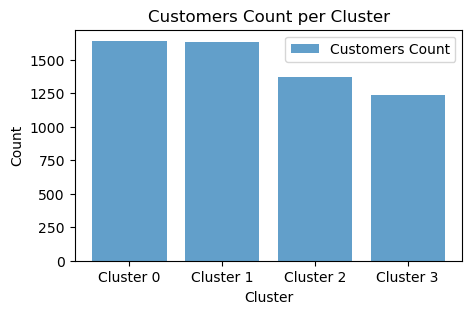

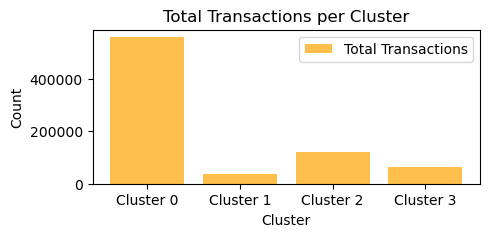

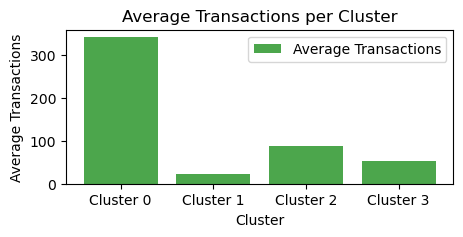

In [206]:
import matplotlib.pyplot as plt

# Plot Customers Count
plt.figure(figsize=(5, 3))
plt.bar(count_summary_table["Cluster"], count_summary_table["Customers Count"], label="Customers Count", alpha=0.7)
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.title("Customers Count per Cluster")
plt.legend()
plt.show()

# Plot Total Transactions
plt.figure(figsize=(5,2))
plt.bar(count_summary_table["Cluster"], count_summary_table["Total Transactions"], label="Total Transactions", color='orange', alpha=0.7)
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.title("Total Transactions per Cluster")
plt.legend()
plt.show()

# Plot Average Transaction
plt.figure(figsize=(5,2))
plt.bar(count_summary_table["Cluster"], count_summary_table["Average Transactions"], label="Average Transactions", color='green', alpha=0.7)
plt.xlabel("Cluster")
plt.ylabel("Average Transactions")
plt.title("Average Transactions per Cluster")
plt.legend()
plt.show()


In [117]:
#### K=2 Transactions 

# # Print number of Customers
# print('Customers Count by Cluster')
# for cluster in range(0,2):
#     print(f'Cluster {cluster}: {len(labeled_rfm_expanded[labeled_rfm_expanded.k2_cluster == cluster])}')

# print('---')

# # Print number of Transactions
# print('Total Transaction Count by Cluster')
# for cluster in range(0,2):
#     print(f'Cluster {cluster}: {len(labeled_has_id[labeled_has_id.k2_cluster == cluster])}')

# print('---')

# # Print average transactions per customer
# print('Agerage Transaction Count by Cluster')
# for cluster in range(0,2):
#     print(f'Cluster {cluster}: {round((len(labeled_has_id[labeled_has_id.k2_cluster == cluster])/len(labeled_rfm_expanded[labeled_rfm_expanded.k4_cluster == cluster])),2)}')

In [163]:
# # Print number of Customers
# print('Frequency  by Cluster')
# for cluster in range(0,4):
#     print(f'Cluster {cluster}')
#     print(labeled_rfm_expanded[labeled_rfm_expanded.k4_cluster == cluster].Frequency.describe().round(2))
#     print('---')

frequency_summary_table = pd.DataFrame({
    f'Cluster {cluster}': labeled_rfm_expanded[labeled_rfm_expanded.k4_cluster == cluster]
    .Frequency.describe().round(2)
    for cluster in range(4)})

print('Frequency')
frequency_summary_table

Frequency


,Cluster 0,Cluster 1,Cluster 2,Cluster 3
count,1640.0,1634.0,1372.0,1232.0
mean,15.78,1.23,4.49,2.37
std,21.68,0.45,2.65,1.17
min,2.0,1.0,1.0,1.0
25%,7.0,1.0,3.0,1.0
50%,11.0,1.0,4.0,2.0
75%,17.0,1.0,5.0,3.0
max,398.0,4.0,41.0,7.0


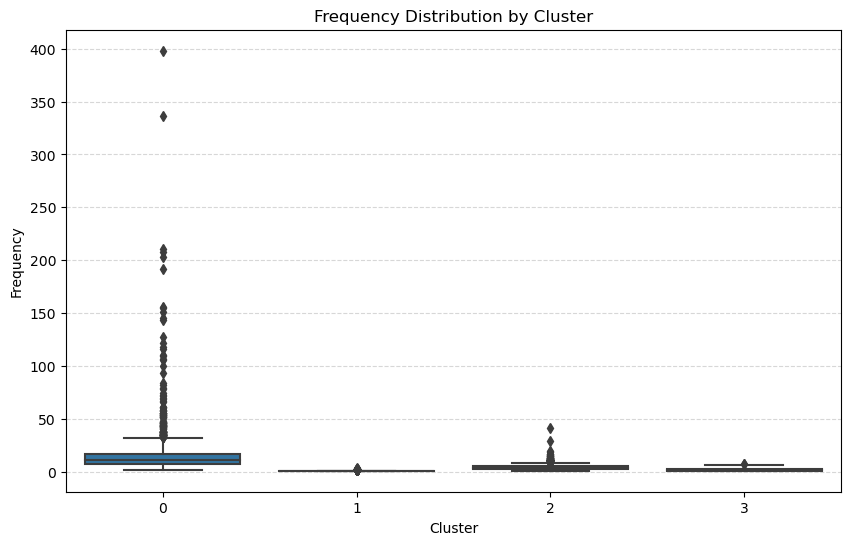

In [204]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x=labeled_rfm_expanded.k4_cluster, y=labeled_rfm_expanded.Frequency)

# Formatting
plt.title("Frequency Distribution by Cluster")
plt.xlabel("Cluster")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


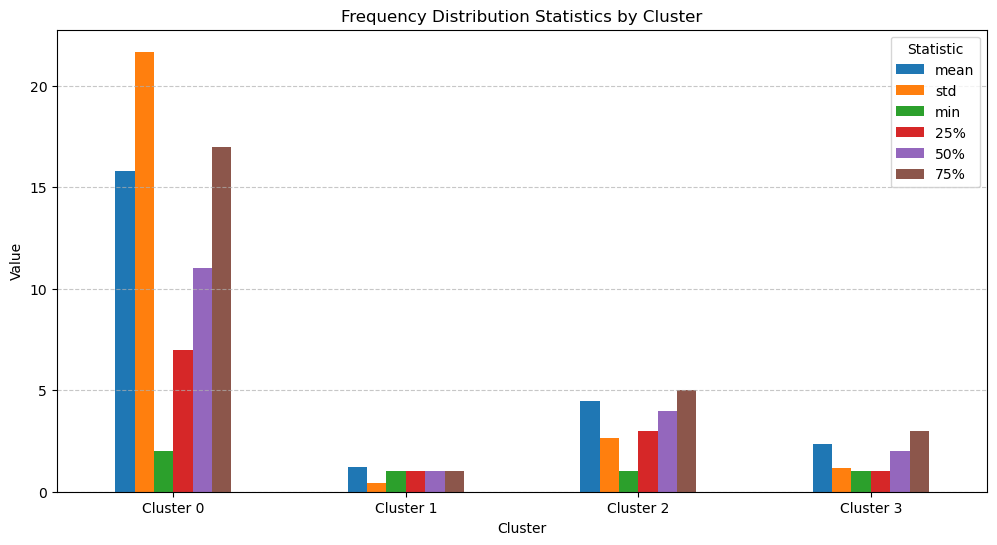

In [196]:
import matplotlib.pyplot as plt

# Transpose the dataframe so clusters are on the x-axis
freq_summary_transposed = frequency_summary_table.T.drop(columns=['count', 'max'])

# Plot grouped bar chart
freq_summary_transposed.plot(kind='bar', figsize=(12, 6))

# Formatting
plt.title("Frequency Distribution Statistics by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Value")
plt.legend(title="Statistic", bbox_to_anchor=(1, 1))
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [212]:
labeled_rfm_expanded.columns

Index(['Customer ID', 'Recency', 'Frequency', 'Monetary', 'AOV', 'Lifespan',
       'CLV', 'k2_cluster', 'k4_cluster'],
      dtype='object')

/Users/ness/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


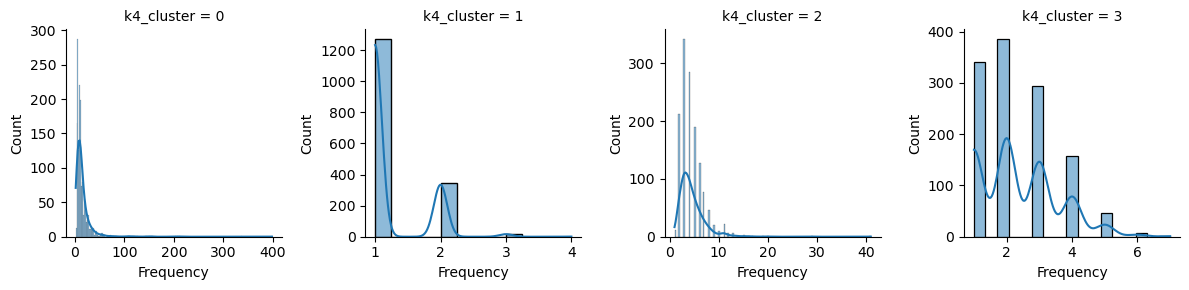

In [230]:
g = sns.FacetGrid(labeled_rfm_expanded[['Recency', 'Frequency', 'Monetary','k4_cluster']], col="k4_cluster", col_wrap=4, sharex=False, sharey=False)
g.map(sns.histplot, "Frequency", kde=True)

plt.show()

CLV

In [167]:
clv_summary_table = pd.DataFrame({
    f'Cluster {cluster}': labeled_rfm_expanded[labeled_rfm_expanded.k4_cluster == cluster]
    .CLV.describe().round(2)
    for cluster in range(4)})

print('CLV')
clv_summary_table

CLV


,Cluster 0,Cluster 1,Cluster 2,Cluster 3
count,1640.0,1634.0,1372.0,1232.0
mean,5194787.08,174313.98,995138.95,401521.27
std,16104415.06,157313.58,1580675.08,319946.44
min,687.72,12.75,269.09,77.5
25%,1235863.97,72578.7,406439.63,180850.69
50%,2226886.18,136506.23,692058.12,328335.83
75%,4372185.9,234143.65,1133411.33,546664.25
max,336391509.19,1535395.71,29019295.5,3222683.48


In [90]:
def describe(df, col):
    for cluster in range(0,4):
        print(f'Cluster {cluster}')
        
        loop_df = df[df.k4_cluster == cluster]
        
        print(loop_df[col].describe().round(2))
        print('---')

        
        # sns.boxplot(x = loop_df[col], orient='h')
        # plt.title(f'Histogram for {col}, cluster {cluster}')
        # plt.ylabel('Frequency')
        # plt.xlabel(f'{col}')
        # plt.show()

In [92]:
describe(labeled_has_id, 'Sales')

Cluster 0
count   559711.0
mean       24.67
std       260.24
min          0.0
25%         5.04
50%         12.6
75%         19.8
max     168469.6
Name: Sales, dtype: float64
---
Cluster 1
count   35306.0
mean       13.6
std       24.52
min         0.0
25%        3.75
50%        10.2
75%       16.95
max      1569.6
Name: Sales, dtype: float64
---
Cluster 2
count   119824.0
mean       18.93
std       139.17
min          0.0
25%         5.04
50%         12.6
75%        17.85
max      38970.0
Name: Sales, dtype: float64
---
Cluster 3
count   64584.0
mean      12.63
std       28.39
min         0.0
25%         3.3
50%        8.85
75%        16.5
max      3861.0
Name: Sales, dtype: float64
---


Takeaways:
* 

## NOTES to self


save labeled_rfm_expanded and labeled_has_id for export